## 1. 모듈 및 분석 환경 설정

#### 1) 모듈 불러오기

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
%matplotlib inline

#### 2) 분석 환경 설정

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print('Current cuda device is', device)

Current cuda device is cuda


#### 3) 하이퍼파라미터 지정

In [7]:
batch_size = 50
epoch_num = 14
# learning_rate : 가중치 업데이트 정도
learning_rate = 0.0001

## 2. 데이터 불러오기

#### 1) MNIST 데이터 불러오기

In [8]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

print('number of training data :', len(train_data))
print('number of test data : ', len(test_data))

1.3%

31.0%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

73.9%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



102.8%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



112.7%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

number of training data : 60000
number of test data :  10000


#### 2) MNIST 데이터 확인

- squueze() 
    - MNIST 데이터는 3차원이므로 2차원으로 줄이기 위해 사용
    - 크기가 1인 차원을 없애는 함수

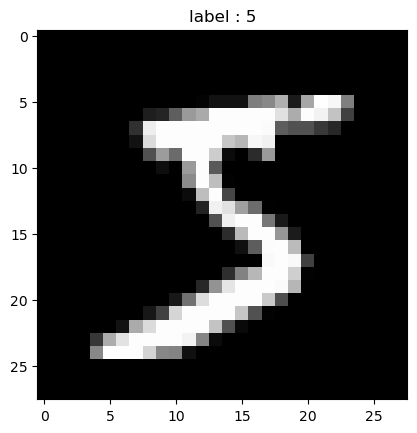

In [12]:
image, label = train_data[0]
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label : %s' % label)
plt.show()

#### 3) 미니배치 구성

In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=True)

first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


## 3. 모델 학습

#### 1) CNN 구조 설계

In [21]:
class CNN(nn.Module) :
    def __init__(self) :
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x) :
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # 열 기준으로 max값
        output = F.log_softmax(x, dim=1)
        return output

#### 2) 옵티마이저 및 손실함수 정의

- CNN 클래스를 이용해 model이라는 인스턴스 생성
- 손실함수를 최소로 하는 **가중치**를 찾기 위해 Adam 알고리즘의 optimizer 지정

In [22]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

#### 3) 설계한 CNN 모형 확인하기

In [23]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


#### 4) 모델학습

In [24]:
# CNN 클래스가 저장된 model 인스턴스를 **학습 모드**로 실행할 것을 명시
model.train()

# 반복 학습 중 손실 함수 현황을 확인하고자, 학습 횟수를 나타내는 보조 인덱스(i)를 지정
i = 0
for epoch in range(epoch_num) :
    # 학습 데이터를 batch_size로 나눈 만큼 반복 수행되며, train_loader는 매 시행마다 미니배치의 데이터와 정답을 저장
    for data, target in train_loader : 
        # 미니 배치의 데이터와 정답을 기존에 지정한 장비 device에 할당
        data = data.to(device)
        target = target.to(device)
        # 학습을 시작하기 전, 이전 반복 시행에서 저장된 optimizer의 Gradient를 초기화
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        # 손실함수를 통해 Gradient 계산
        loss.backward()
        # 위에서 계산된 Gradient를 통해 모델의 가중치를 업데이트
        optimizer.step()
        if i % 1000 == 0 :
            print('Train Step : {}\tLoss : {:.3f}'.format(i, loss.item()))
        i += 1

/home/ubuntu/anaconda3/envs/nozzi/lib/python3.9/site-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Step : 0	Loss : 2.301
Train Step : 1000	Loss : 1.237
Train Step : 2000	Loss : 0.993
Train Step : 3000	Loss : 1.342
Train Step : 4000	Loss : 1.106
Train Step : 5000	Loss : 0.987
Train Step : 6000	Loss : 1.134
Train Step : 7000	Loss : 0.965
Train Step : 8000	Loss : 1.035
Train Step : 9000	Loss : 1.168
Train Step : 10000	Loss : 1.192
Train Step : 11000	Loss : 1.163
Train Step : 12000	Loss : 1.100
Train Step : 13000	Loss : 1.198
Train Step : 14000	Loss : 1.098
Train Step : 15000	Loss : 1.066
Train Step : 16000	Loss : 1.430


## 4. 모델 평가

- model.eval()
    - 평가모드를 실행하기 위해 명시하는 함수
    - 이 함수를 호출하면, Dropout이 적용되지 않고, BatchNormalization도 평가 모드로 전환

In [25]:
model.eval()
correct = 0
for data, target in test_loader :
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    # 1(열)을 기준으로 최대값 반환 & values와 indices 중에서 indices 반환
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

In [45]:
print('Test set: Accuracy: {:.2f}%'.format(100*correct/len(test_loader.dataset)))

Test set: Accuracy: 98.90%
